### Import packages for the simulation

In [6]:
# Normal staple packages
import numpy as np
%matplotlib inline 
# notebook
import matplotlib.pyplot as plt
import scipy.io as sio

# Bloch simulator 
from bloch.bloch import bloch
from bloch.min_time_gradient import minimum_time_gradient

### Define the grid of spins for our simulation. 

In [95]:
class SpinGrid:
    height = 10 # height of the grid in cm 
    width = 10 # width of the grid in cm
    flow_rate = 5 # flow rate in cm/s. assume vertical flow, with positive corresponding to going up. 
    # region of the grid where the flow is present given by a min and max x coordinate.
    # assume that all flowing material is blood, the rest is muscle. 
    flow_region = [-2, 2] 
    delta_x = 0.1 # grid spacing in cm
    delta_y = 0.1 # grid spacing in cm
    coil_file= None # file containing the shape of the coil, will be used to generate the coil field. 
    
    # TODO: fill in appropraite T1s, and name of other material. 
    T1_moving = -1 
    T2_moving = -1
    T1_static = -1
    T2_static = -1
    M_0 = 1 # initial magnetization of fresh spins 


    def __init__(self, height, width, flow_rate, flow_region, delta_x, delta_y):
        self.height = height
        self.width = width
        self.flow_rate = flow_rate
        self.flow_region = flow_region
        self.delta_x = delta_x
        self.delta_y = delta_y

        # TODO: create a grid of positions,and magnetizations. Additionally, calculate 
        # a list of indices for the flowing vs. static columns. 
        self.n_spins_x = int(self.width / self.delta_x)
        self.n_spins_y = int(self.height / self.delta_y)
        x_positions = np.linspace(-self.width/2, self.width/2, self.n_spins_x)
        y_positions = np.linspace(-self.height/2, self.height/2, self.n_spins_y)

        # Create a n_spins_x by n_spins_y grid of positions as the product of the x and y positions
        self.x_positions, self.y_positions = np.meshgrid(x_positions, y_positions)

        # Create the magnetizations 
        self.mxs = self.M_0 * np.zeros((self.n_spins_y, self.n_spins_x))
        self.mys = self.M_0 * np.zeros((self.n_spins_y, self.n_spins_x))
        self.mzs = self.M_0 * np.ones((self.n_spins_y, self.n_spins_x))
        
        # List of columns that are flowing 
        start_index = int((flow_region[0] - (-width/2)) / self.delta_x)
        end_index = int((flow_region[1] - (-width/2)) / self.delta_x)
        self.flowing_columns = np.array(range(start_index, end_index))
        self.static_columns = np.concatenate((np.array(range(0, start_index)), np.array(range(end_index, self.n_spins_x))))

    def simulate_flow(self, delta_t):
        """ 
            Simulate the flow of blood through the grid
            delta_t: time to simulate in seconds
            
            Updates the grid by shifting the flowing columns appropriately. 
            Additionaly fills in fresh material in the space the flow has moved out of. 
        """
        # TODO: fill this in 
        pass

    
    def get_all_positions(self):
        """
            Return a 2 x num_spins array of all of the positions in the grid    
        """
        x_positions = self.x_positions.flatten()
        y_positions = self.y_positions.flatten()
        return np.vstack((x_positions, y_positions))

    def get_static_positions(self):
        """
            Return a 2 x num_static array of all of the positions of the static material   
        """
        all_positions = self.get_all_positions()
        return all_positions[:, self.static_columns]
    
    def get_moving_positions(self):
        """
            Return a 2 x num_moving array of all of the positions of the moving material    
        """
        all_positions = self.get_all_positions()
        return all_positions[:, self.flowing_columns] 


    def get_all_magnetizations(self):
        """
            Return a 2 x num_spins array of all of the magnetizations in the grid    
        """
        mxs = self.mxs.flatten()
        mys = self.mys.flatten()
        mzs = self.mzs.flatten()
        return mxs, mys, mzs
    
    def set_all_magnetizations(self, mxs, mys, mzs):
        """
            Set the magnetizations of the grid to the given mxs, mys, and mzs
        """
        self.mxs = mxs.reshape((self.n_spins_y, self.n_spins_x))
        self.mys = mys.reshape((self.n_spins_y, self.n_spins_x))
        self.mzs = mzs.reshape((self.n_spins_y, self.n_spins_x))

    def get_static_magnetizations(self):
        """
            Return a 2 x num_static array of the static magnetizations, indexed the same as the positions.    
        """
        all_magnetizations = self.get_all_magnetizations()
        return all_magnetizations[:, self.static_columns]
        
    def set_static_magnetizations(self, new_mxs, new_mys, new_mzs):
        """
            Take in a 1 x num_static array of magnetizations in the x, y, and z direction, and
            appropriately reshape and set the magnetizations of the spins in the static columns.
        """
        self.mxs[:, self.static_columns] = new_mxs.reshape((self.n_spins_y, len(self.static_columns)))
        self.mys[:, self.static_columns] = new_mys.reshape((self.n_spins_y, len(self.static_columns)))
        self.mzs[:, self.static_columns] = new_mzs.reshape((self.n_spins_y, len(self.static_columns)))

    def get_flowing_magnetizations(self):
        """
            Return a 2 x num_moving array of the moving magnetizations, indexed the same as the positions.
        """
        all_magnetizations = self.get_all_magnetizations()
        return all_magnetizations[:, self.flowing_columns]
    
    def set_flowing_magnetizations(self, new_mxs, new_mys, new_mzs):
        """
            Take in a 1 x num_moving array of magnetizations in the x, y, and z direction, and
            appropriately reshape and set the magnetizations of the spins in the moving columns.
        """
        self.mxs[:, self.flowing_columns] = new_mxs.reshape((self.n_spins_y, len(self.flowing_columns)))
        self.mys[:, self.flowing_columns] = new_mys.reshape((self.n_spins_y, len(self.flowing_columns)))
        self.mzs[:, self.flowing_columns] = new_mzs.reshape((self.n_spins_y, len(self.flowing_columns)))

    def visualize_grid(self):
        """
            Visualize the grid, and the flow region.
            Using the 2-d arrays x_position and y_position, plot a 
            circle at each position, with the color corresponding to the magnitude of the 
            x, y magnetization.
        """
        # Loop through the positions, and plot a circle at each position
        fig, ax = plt.subplots()
        ax.axis('equal')
        for i in range(self.n_spins_x):
            for j in range(self.n_spins_y):
                x = self.x_positions[i][j]
                y = self.y_positions[i][j]
                mx = self.mxs[i][j]
                my = self.mys[i][j]
                mz = self.mzs[i][j]

                # Plot a circle at x, y
                # ax.add_patch(plt.Circle((x, y), np.minimum(self.delta_x, self.delta_y), color=(mx, my, mz)))
                circle = plt.Circle((x, y), self.delta_x/2, color = 0.5*np.array([mx, my, mz]))
                ax.add_patch(circle)

        plt.xlim(-1.1*self.width/2, 1.1*self.width/2)
        plt.ylim(-1.1*self.height/2, 1.1*self.height/2)

        #ax.add_patch(plt.Circle((0, 0), 1.0, color='r'))

    def off_resonance_from_coil(self):
        """
            Return a [2 x num_spins] array of the off resonance frequency of each spin, in Hz.
        """
        pass
        
    def off_resonance_from_coil_static(self):
        """
            Return a [2 x num_static] array of the off resonance frequency of each static spin, in Hz.
        """
        pass

    def off_resonance_from_coil_moving(self):
        """
            Return a [2 x num_moving] array of the off resonance frequency of each moving spin, in Hz.
        """
        pass 

    def plot_coil_field(self):
        """
            Plot the field of the coil. 
        """
        pass



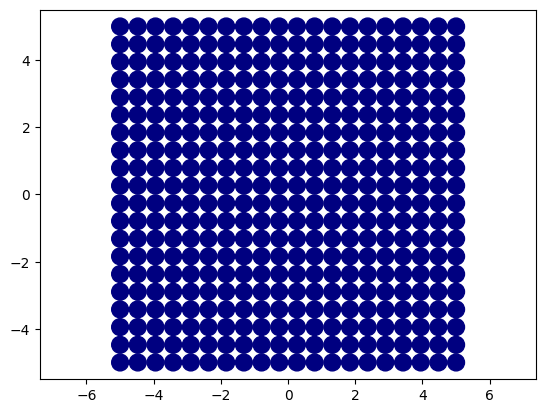

In [96]:
# Try creating a SpinGrid
spin_grid = SpinGrid(10, 10, 5, [-2, 2], 0.5, 0.5)
spin_grid.visualize_grid()




### Simulate and visualize flow on its own without imaging to make sure we can make things flow 


In [97]:
# TODO: set the magnetizations different, then go through several steps of flow and plot at each moment 
# to show the movement of the material and the replenishing of fresh material 

### Create a sequence. 
This will correspond to: b1 (rf) [1 x M], gr (2xM), and readout_indices

In [140]:
def create_ssfp_rf(dt, TR, theta=60):
    """
        Creates an RF pulse for a single TR of the ssfp sequence. TR_index 
        is included in case we want to change the angle depending on the TR. 
    """
    # Create an empty sequence, then calculate the magnitude of a single sample 
    # hard RF pulse to rotate by theta degrees 
    rf_seq = np.zeros(int(TR/dt))
    rf_mag = theta/360/(4257*dt)

    # Add in the magnitude to the first sample then return
    rf_seq[0] = rf_mag
    return rf_seq 


def create_ssfp_sequence(TR, dt, theta=60):
    """
        Create a single TR of an SSFP sequence that just does a single theta degree 
        RF pulse. 

        Returns rf_seq, grad_seq  
    """
    # Create the rf sequence 
    rf_seq = create_ssfp_rf(dt, TR, theta=theta)

    # Create the gradient sequence
    gx = 0 * rf_seq
    gy = 0 * rf_seq 
    grad_seq = np.vstack((gx, gy))

    return rf_seq, grad_seq


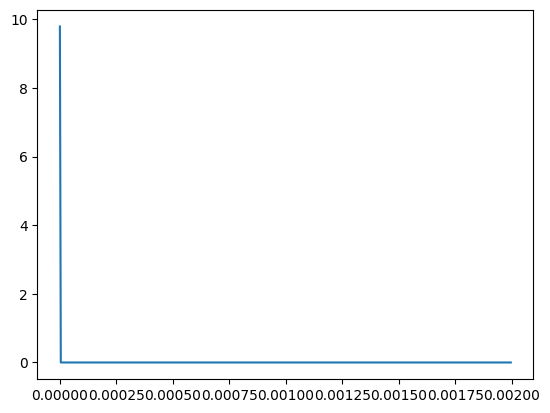

In [141]:
# Create a single TR of the sequence and plot the RF pulse
TR = 2e-3 
dt = 4e-6
rf_seq, grad_seq = create_ssfp_sequence(TR, dt)

# Plot the RF pulse
plt.plot(dt * np.array(range(len(rf_seq))), rf_seq)

In [142]:
len(rf_seq)

500

### Simulate the sequence 

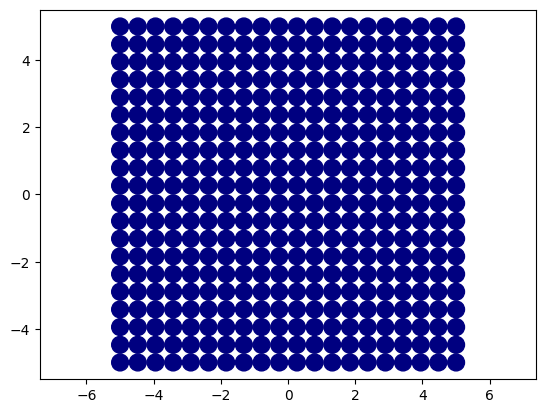

In [149]:
# Define all of the parameters for the simulation 
TR = 10e-3 # 2e-3 
dt = 4e-6
n_TRs = 1000
T1 = 100e-3 # 0.83 
T2 = 100e-3 # 0.08
theta = 90

# Try creating a SpinGrid
spin_grid = SpinGrid(10, 10, 5, [-2, 2], 0.5, 0.5)
spin_grid.visualize_grid()

# Simulate forward through n_TRs, keeping track of the magnetizations at every point in time. 
signal = np.array([])

for i in range(n_TRs):
    # Get the rf and gradient sequence for this TR 
    rf_seq, grad_seq = create_ssfp_sequence(TR, dt, theta=theta)

    # On odd TRs, flip the sign of the rf sequence 
    if i % 2 == 1:
        rf_seq = -rf_seq

    mx, my, mz = spin_grid.get_all_magnetizations() 
    positions = spin_grid.get_all_positions()
    df = 0

    new_mx, new_my, new_mz = bloch(rf_seq, grad_seq, dt, T1, T2, df, positions, 2, mx, my, mz) # magnetizations are num_positions x num_times if no off resonance frequency 
    spin_grid.set_all_magnetizations(new_mx[:, -1], new_my[:, -1], new_mz[:, -1])

    current_signal = np.sum(new_mx, axis=0) + 1j*np.sum(new_my, axis=0)
    signal = np.append(signal, current_signal)

signal_strength = np.abs(signal)

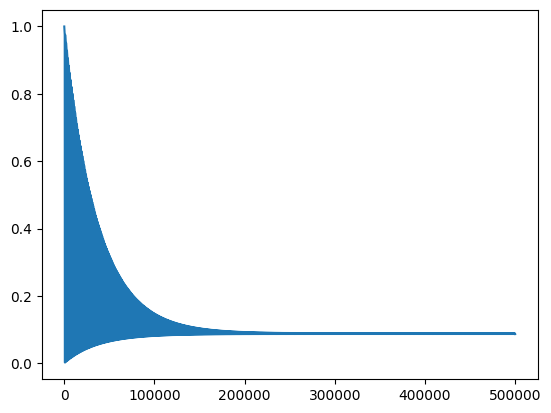

In [150]:
plt.plot(signal_strength / (spin_grid.n_spins_x*spin_grid.n_spins_y))

In [151]:
?bloch

Signature: bloch(b1, gr, tp, t1, t2, df, dp, mode, mx=None, my=None, mz=None)
Docstring:
Bloch simulation of rotations due to B1, gradient and
off-resonance, including relaxation effects.  At each time
point, the rotation matrix and decay matrix are calculated.
Simulation can simulate the steady-state if the sequence
is applied repeatedly, or the magnetization starting at m0.

INPUT:
        b1 = (1xM) RF pulse in G.  Can be complex.
        gr = ((1,2,or 3)xM) 1,2 or 3-dimensional gradient in G/cm.
        tp = (1xM) time duration of each b1 and gr point, in seconds,
                        or 1x1 time step if constant for all points
                        or monotonically INCREASING endtime of each
                        interval..
        t1 = T1 relaxation time in seconds.
        t2 = T2 relaxation time in seconds.
        df = (1xN) Array of off-resonance frequencies (Hz)
        dp = ((1,2,or 3)xP) Array of spatial positions (cm).
                Width should match width of gr

### Reconstruct an image

### Create a 